# ZOIDBERG 2.0

L'objectif est de founir un IA permettant de reconnaitre, via une radiographie, si les poumons presentent un risque de pneumonie.

COMPUTER AIDED DIAGNOSIS

## IMPORTS

In [11]:
import glob
import os
import numpy

from PIL import Image
from matplotlib import pyplot
from numpy import asarray
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

## HELPERS

In [12]:
def open_image(path):
    image = None
    try:
        image = Image.open(path)
    except:
        print('Could not open file ' + path)
    return image

In [13]:
def image_to_array(image):
    return asarray(image)

In [14]:
def array_to_image(array):
    Image.fromarray(array)

In [15]:
def crop_image(image, new_size={'x': 1000, 'y': 1000}):
    width, height = image.size
    left, upper, right, lower = 0, 0, width, height

    if width > height:
        offset = int((width - height) / 2)
        left = offset
        right = offset + height
    else:
        offset = int((height - width) / 2)
        left = offset
        right = offset + width
    return image.crop((left, upper, right, lower)).resize((new_size['x'], new_size['y']))

In [16]:
def array_infos_match(arr, debug=False, size={'x': 1000, 'y': 1000}, img_type='uint8'):
    if debug:
        if arr is not None:
            print('Shape: %s' % (arr.shape,))
            print('Ratio: %s' % str(arr.shape[1] / arr.shape[0]))
            print('Type : %s' % arr.dtype)
            return True
        else:
            print('no image!')
            return False
    return arr is not None and arr.shape == (size['x'], size['y']) and arr.dtype == img_type

In [17]:
def show_image(image):
    image.show()

In [18]:
def show_array(array):
    pyplot.imshow(array)
    pyplot.show()

In [19]:
def load_images(directory, label, limit=-1, size={'x': 1000, 'y': 1000}, extension='.jpeg'):
    pattern = '' if label == 'healthy' else label
    images = [] if not os.path.isdir(directory) else glob.glob(directory + '/*' + pattern + '*' + extension)
    res = []
    labels = []

    print('loading ' + label + ' pictures from ' + directory + ' ...')

    if 0 <= limit < len(images):
        images = images[:limit]

    for image in images:
        array = image_to_array(crop_image(open_image(image), size))
        #print(array.shape)
        if not array_infos_match(array, False, size):
            print('wrong size for: ' + image)
            continue
        res.append(array.reshape(-1))
        labels.append(label)

    return {
        'images': res,
        'labels': labels
    }

## ASSETS LOADING

### Display sample

Shape: (1858, 2090)
Ratio: 1.1248654467169
Type : uint8


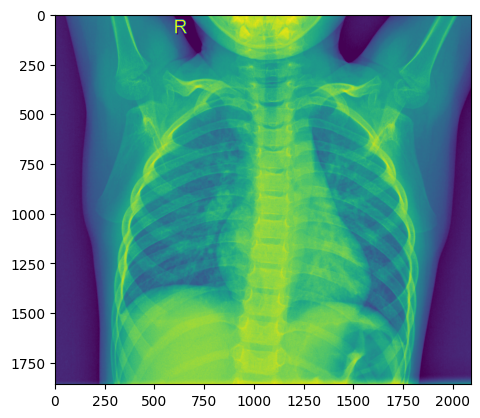

In [20]:
sample = './assets/chest_Xray/train/NORMAL/IM-0115-0001.jpeg'
vanillaImage = open_image(sample)
vanillaArray = image_to_array(vanillaImage)
array_infos_match(vanillaArray, True)
#show_image(vanillaImage)
show_array(vanillaArray)


### Display cropped sample

Shape: (1000, 1000)
Ratio: 1.0
Type : uint8


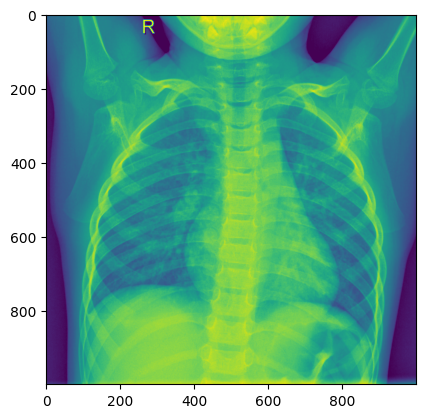

In [21]:
croppedImage = crop_image(vanillaImage)
croppedArray = image_to_array(croppedImage)
array_infos_match(croppedArray, True)
show_array(croppedArray)

### Load assets

In [22]:
dataset_file = './assets/lungs_dataset.json'
assets_path = './assets/chest_Xray'
assets = None

if os.path.exists(assets_path):
    print('Loading assets from images')
    image_size = {'x': 500, 'y': 500}

    assets = {
        'test': {
            'healthy': load_images(assets_path + '/test/NORMAL', 'healthy', (-1), image_size),
            'bacteria': load_images(assets_path + '/test/PNEUMONIA', 'virus', (-1), image_size),
            'virus': load_images(assets_path + '/test/PNEUMONIA', 'bacteria', (-1), image_size)
        },
        'train': {
            'healthy': load_images(assets_path + '/train/NORMAL', 'healthy', 400, image_size),
            'bacteria': load_images(assets_path + '/train/PNEUMONIA', 'virus', 400, image_size),
            'virus': load_images(assets_path + '/train/PNEUMONIA', 'bacteria', 400, image_size)
        },
        #'val': {
        #    'healthy': load_images(assets_path + '/val/NORMAL', 'healthy'),
        #    'bacteria': load_images(assets_path + '/val/PNEUMONIA', 'virus'),
        #    'virus': load_images(assets_path + '/val/PNEUMONIA', 'bacteria')
        #}
    }

    print('Loading assets from images: done!')
else:
    print('assets not found !')

Loading assets from images
loading healthy pictures from ./assets/chest_Xray/test/NORMAL ...
loading virus pictures from ./assets/chest_Xray/test/PNEUMONIA ...
loading bacteria pictures from ./assets/chest_Xray/test/PNEUMONIA ...
loading healthy pictures from ./assets/chest_Xray/train/NORMAL ...
loading virus pictures from ./assets/chest_Xray/train/PNEUMONIA ...
wrong size for: ./assets/chest_Xray/train/PNEUMONIA\person1010_virus_1695.jpeg
wrong size for: ./assets/chest_Xray/train/PNEUMONIA\person1052_virus_1751.jpeg
wrong size for: ./assets/chest_Xray/train/PNEUMONIA\person1099_virus_1819.jpeg
wrong size for: ./assets/chest_Xray/train/PNEUMONIA\person1104_virus_1826.jpeg
wrong size for: ./assets/chest_Xray/train/PNEUMONIA\person1108_virus_1833.jpeg
wrong size for: ./assets/chest_Xray/train/PNEUMONIA\person1129_virus_1857.jpeg
wrong size for: ./assets/chest_Xray/train/PNEUMONIA\person1132_virus_1863.jpeg
wrong size for: ./assets/chest_Xray/train/PNEUMONIA\person1133_virus_1865.jpeg
wro

Display sample from loaded asset

In [23]:
#show_array(assets['train']['healthy']['images'][0])

## LOGIC

### Training Model

In [24]:
clf = svm.SVC()

train_data = assets['train']['healthy']['images'] + assets['train']['bacteria']['images'] + assets['train']['virus']['images']
train_labels = assets['train']['healthy']['labels'] + assets['train']['bacteria']['labels'] + assets['train']['virus']['labels']

print('Training model')

clf.fit(train_data, train_labels)

Training model


SVC()

### Testing Model

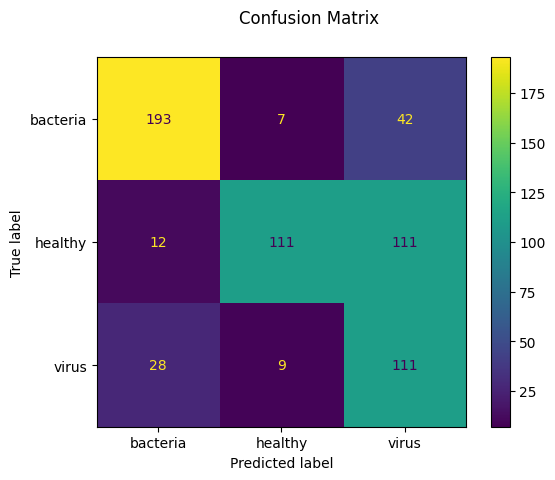

In [25]:
test_data = assets['test']['healthy']['images'] + assets['test']['bacteria']['images'] + assets['test']['virus']['images']
test_labels = assets['test']['healthy']['labels'] + assets['test']['bacteria']['labels'] + assets['test']['virus']['labels']

predicted = clf.predict(test_data)

disp = metrics.ConfusionMatrixDisplay.from_predictions(test_labels, predicted)
disp.figure_.suptitle('Confusion Matrix')

plt.show()